# Flow Traders Share Buy Back

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import yfinance as yf

import utils

C:\Users\tomw1\AppData\Local\Temp\ipykernel_18800\2006342296.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
START = dt.date(2015, 1, 1)
END = dt.date.today()

In [3]:
ENTRY_DETAILS = {"month": 9, "day": 1}
EXIT_DETAILS = {"month": 2, "day": 1}

In [4]:
def get_earnings(ticker: str, start: dt.date) -> pd.DataFrame:

    if "." in ticker:
        name, ext = ticker.split(".")
    else:
        name, ext = ticker, "US"

    url = f'https://eodhd.com/api/calendar/earnings?symbols={name}.{ext}&from={start}&api_token=65a9557c3df693.14557024&fmt=json'
    print(url)
    data = requests.get(url).json()
    data = pd.DataFrame(data["earnings"])
    
    data["report_date"] = data["report_date"].apply(lambda date: pd.Timestamp(date))
    data["date"] = data["date"].apply(lambda date: pd.Timestamp(date))

    return data
    

## Rules

1. Enter before share buy back begins.
2. Exit after share buy back ends.

In [5]:
TICKER = "FLOW.AS"
# TICKER = "VIRT"
# TICKER = "C"

### Get Data

In [6]:
data = yf.download(TICKER, progress=False)["Adj Close"]
data = data.to_frame(name=TICKER)
data.head(5)

C:\Users\tomw1\AppData\Local\pypoetry\Cache\virtualenvs\quantified-strategies-wFBlb7GR-py3.11\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,FLOW.AS
Date,
2015-07-10,20.753988
2015-07-13,20.725323
2015-07-14,21.183973
2015-07-15,22.072615
2015-07-16,21.986612


In [7]:
data = data.loc[(data.index.date >= START) & (data.index.date <= END)]
data.head(5)

,FLOW.AS
Date,
2015-07-10,20.753988
2015-07-13,20.725323
2015-07-14,21.183973
2015-07-15,22.072615
2015-07-16,21.986612


In [8]:
earnings = get_earnings(ticker=TICKER, start=data.index[0].date())
earnings["impact_date"] = np.where(earnings["before_after_market"] == "BeforeMarket", earnings["report_date"] - dt.timedelta(days=1), earnings["report_date"])
earnings.head(5)

https://eodhd.com/api/calendar/earnings?symbols=FLOW.AS&from=2015-07-10&api_token=65a9557c3df693.14557024&fmt=json


,code,report_date,date,before_after_market,currency,actual,estimate,difference,percent,impact_date
0,FLOW.AS,2015-11-13,2015-09-30,AfterMarket,EUR,0.81,0.55,0.26,47.2727,2015-11-13
1,FLOW.AS,2016-02-24,2015-12-31,BeforeMarket,EUR,0.64,0.58,0.06,10.3448,2016-02-23
2,FLOW.AS,2016-05-04,2016-03-31,BeforeMarket,EUR,0.50,0.54,-0.04,-7.4074,2016-05-03
3,FLOW.AS,2016-08-12,2016-06-30,BeforeMarket,EUR,0.62,0.58,0.04,6.8966,2016-08-11
4,FLOW.AS,2016-11-09,2016-09-30,BeforeMarket,EUR,0.32,0.39,-0.07,-17.9487,2016-11-08


### Get returns

In [9]:
data["ret"] = data[TICKER].pct_change()
data["ret_shifted"] = data["ret"].shift(-1)
data.head(5)

,FLOW.AS,ret,ret_shifted
Date,,,
2015-07-10,20.753988,NaN,-0.001381
2015-07-13,20.725323,-0.001381,0.022130
2015-07-14,21.183973,0.022130,0.041949
2015-07-15,22.072615,0.041949,-0.003896
2015-07-16,21.986612,-0.003896,0.000000


### Entry Flag

In [10]:
data["entry_month"] = data.index.month == ENTRY_DETAILS["month"]
data["entry_day"] = (data.index.day >= ENTRY_DETAILS["day"]) & data["entry_month"]
data["entry_flag"] = data["entry_day"].diff().fillna(False).astype(bool) & data["entry_day"]
FIRST_ENTRY = data.loc[data["entry_flag"] == 1].index[0]
FIRST_ENTRY

C:\Users\tomw1\AppData\Local\Temp\ipykernel_18800\3017518255.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["entry_flag"] = data["entry_day"].diff().fillna(False).astype(bool) & data["entry_day"]


Timestamp('2015-09-01 00:00:00')

In [11]:
data.loc[data["entry_flag"]].head(5)

,FLOW.AS,ret,ret_shifted,entry_month,entry_day,entry_flag
Date,,,,,,
2015-09-01,21.535183,-0.024740,-0.000135,True,True,True
2016-09-01,16.271225,0.001320,0.052761,True,True,True
2017-09-01,13.981224,-0.037069,0.022551,True,True,True
2018-09-03,17.127586,0.003180,-0.003962,True,True,True
2019-09-02,17.380735,-0.004914,-0.008230,True,True,True


### Exit Flag

In [12]:
data["exit_month"] = data.index.month == EXIT_DETAILS["month"]
data["exit_day"] = (data.index.day >= EXIT_DETAILS["day"]) & data["exit_month"]
data["exit_flag"] = data["exit_day"].diff().fillna(False).astype(bool) & data["exit_day"] & (data.index > FIRST_ENTRY) 

C:\Users\tomw1\AppData\Local\Temp\ipykernel_18800\2152852349.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["exit_flag"] = data["exit_day"].diff().fillna(False).astype(bool) & data["exit_day"] & (data.index > FIRST_ENTRY)


In [13]:
data.loc[data["exit_flag"]].head(5)

,FLOW.AS,ret,ret_shifted,entry_month,entry_day,entry_flag,exit_month,exit_day,exit_flag
Date,,,,,,,,,
2016-02-01,28.076233,0.035251,0.020907,False,False,False,True,True,True
2017-02-01,20.204897,0.018862,0.001366,False,False,False,True,True,True
2018-02-01,12.866548,0.001984,0.004951,False,False,False,True,True,True
2019-02-01,18.281189,-0.002222,0.004454,False,False,False,True,True,True
2020-02-03,14.719982,-0.021863,0.030126,False,False,False,True,True,True


### Get Position

In [14]:
data["delta_pos"] = data["entry_flag"].astype(int) - data["exit_flag"].astype(int)
data["pos"] = data["delta_pos"].cumsum()
data["inv_pos"] = 1 - data["pos"]
data["pos"] = np.where(data.index.isin(earnings["impact_date"].tolist()), 0, data["pos"])
data["inv_pos"] = np.where(data.index.isin(earnings["impact_date"].tolist()), 0, data["inv_pos"])
data["earnings_date_pos"] = data.index.isin(earnings["impact_date"].tolist()).astype(int)
data.loc[data["pos"] != 0.0].head(5)

,FLOW.AS,ret,ret_shifted,entry_month,entry_day,entry_flag,exit_month,exit_day,exit_flag,delta_pos,pos,inv_pos,earnings_date_pos
Date,,,,,,,,,,,,,
2015-09-01,21.535183,-0.024740,-0.000135,True,True,True,False,False,False,1,1,0,0
2015-09-02,21.532280,-0.000135,0.000000,True,True,False,False,False,False,0,1,0,0
2015-09-03,21.532280,0.000000,-0.004723,True,True,False,False,False,False,0,1,0,0
2015-09-04,21.430576,-0.004723,0.008949,True,True,False,False,False,False,0,1,0,0
2015-09-07,21.622364,0.008949,-0.005376,True,True,False,False,False,False,0,1,0,0


### Get Strategy Returns

In [15]:
data["strat_ret"] = data["pos"] * data["ret_shifted"]
data["inv_strat_ret"] = data["inv_pos"] * data["ret_shifted"]
data["ed_ret"] = data["earnings_date_pos"] * data["ret_shifted"]
data.head(5)

,FLOW.AS,ret,ret_shifted,entry_month,entry_day,entry_flag,exit_month,exit_day,exit_flag,delta_pos,pos,inv_pos,earnings_date_pos,strat_ret,inv_strat_ret,ed_ret
Date,,,,,,,,,,,,,,,,
2015-07-10,20.753988,NaN,-0.001381,False,False,False,False,False,False,0,0,1,0,-0.0,-0.001381,-0.0
2015-07-13,20.725323,-0.001381,0.022130,False,False,False,False,False,False,0,0,1,0,0.0,0.022130,0.0
2015-07-14,21.183973,0.022130,0.041949,False,False,False,False,False,False,0,0,1,0,0.0,0.041949,0.0
2015-07-15,22.072615,0.041949,-0.003896,False,False,False,False,False,False,0,0,1,0,-0.0,-0.003896,-0.0
2015-07-16,21.986612,-0.003896,0.000000,False,False,False,False,False,False,0,0,1,0,0.0,0.000000,0.0


### Get Compound Strategy Returns

In [16]:
data["compound_hodl_rets"] = utils.get_cumulative_return(returns=data["ret_shifted"], total=False)
data["compound_strat_rets"] = utils.get_cumulative_return(returns=data["strat_ret"], total=False)
data["compound_inv_strat_rets"] = utils.get_cumulative_return(returns=data["inv_strat_ret"], total=False)
data["compound_ed_rets"] = utils.get_cumulative_return(returns=data["ed_ret"], total=False)
data.head(5)

,FLOW.AS,ret,ret_shifted,entry_month,entry_day,entry_flag,exit_month,exit_day,exit_flag,delta_pos,pos,inv_pos,earnings_date_pos,strat_ret,inv_strat_ret,ed_ret,compound_hodl_rets,compound_strat_rets,compound_inv_strat_rets,compound_ed_rets
Date,,,,,,,,,,,,,,,,,,,,
2015-07-10,20.753988,NaN,-0.001381,False,False,False,False,False,False,0,0,1,0,-0.0,-0.001381,-0.0,-0.001381,0.0,-0.001381,0.0
2015-07-13,20.725323,-0.001381,0.022130,False,False,False,False,False,False,0,0,1,0,0.0,0.022130,0.0,0.020718,0.0,0.020718,0.0
2015-07-14,21.183973,0.022130,0.041949,False,False,False,False,False,False,0,0,1,0,0.0,0.041949,0.0,0.063536,0.0,0.063536,0.0
2015-07-15,22.072615,0.041949,-0.003896,False,False,False,False,False,False,0,0,1,0,-0.0,-0.003896,-0.0,0.059392,0.0,0.059392,0.0
2015-07-16,21.986612,-0.003896,0.000000,False,False,False,False,False,False,0,0,1,0,0.0,0.000000,0.0,0.059392,0.0,0.059392,0.0


## Plot Strategy Results

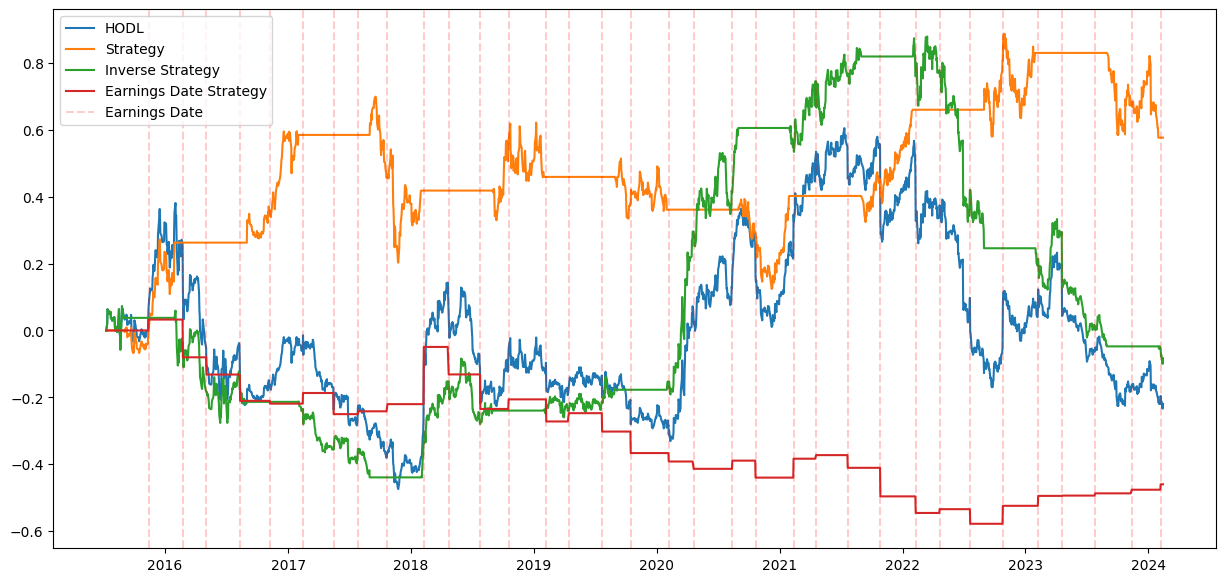

In [17]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(data["compound_hodl_rets"], label="HODL")
ax.plot(data["compound_strat_rets"], label="Strategy")
ax.plot(data["compound_inv_strat_rets"], label="Inverse Strategy")
ax.plot(data["compound_ed_rets"], label="Earnings Date Strategy")

for i, date in enumerate(earnings["impact_date"].tolist()):
    ax.axvline(x=date, color="red", alpha=0.2, linestyle="--", label="Earnings Date" if i == 0 else None)

plt.legend(loc="best")
plt.show()

## Describe Strategy Results

In [18]:
pd.concat([
    utils.describe(returns=data["strat_ret"], pos=data["pos"], daily=True, asset=TICKER).to_frame(name="Strategy"),
    utils.describe(returns=data["inv_strat_ret"], pos=data["inv_pos"], daily=True, asset=TICKER).to_frame(name="Inv. Strategy"),
    utils.describe(returns=data["ed_ret"], pos=data["earnings_date_pos"], daily=True, asset=TICKER).to_frame(name="Earnings Strategy"),
    utils.describe(returns=data["ret_shifted"], daily=True, asset=TICKER).to_frame(name="HODL"),
], axis=1)

,Strategy,Inv. Strategy,Earnings Strategy,HODL
Asset,FLOW.AS,FLOW.AS,FLOW.AS,FLOW.AS
Start,2015-07-10,2015-07-10,2015-07-10,2015-07-10
End,2024-02-15,2024-02-15,2024-02-15,2024-02-15
Mean Return,0.05968%,0.00990%,-1.49739%,0.00819%
Total Return,57.65%,-8.30%,-46.01%,-21.94%
Median Return,0.00000%,0.00000%,-0.44093%,0.00000%
1st Quartile,-0.78165%,-0.92018%,-8.32127%,-0.86756%
3rd Quartile,0.92191%,0.92349%,3.25633%,0.93325%
Std Dev Return,1.54560%,1.84571%,7.90150%,1.97069%
CAGR,4.773 bps,-0.712 bps,-179.633 bps,-1.123 bps
